In [2]:
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from keras.layers import Bidirectional, RepeatVector, TimeDistributed, Permute, Embedding
from keras.layers import concatenate, add, Lambda, multiply
from keras.layers import LSTM
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences

from keras.applications import imagenet_utils, Xception
from keras.preprocessing.image import img_to_array
import keras.backend as K

import numpy as np 
import json
import os
import cv2
import h5py
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
from helpers import TrainingMonitor
from helpers import Utils

In [5]:
X_file = open('../input/dataset/X.pickle', 'rb')
x = pickle.load(X_file)
X_file.close()

In [6]:
Y_file = open('../input/dataset/Y.pickle', 'rb')
y = pickle.load(Y_file)
Y_file.close()

In [7]:
y = np.array(y)

In [8]:
y_input = np.zeros([1000, 10])
y_input[:, 1:] = y[:,:-1]
y_input[:, 0] = -1

In [9]:
y_input[0]

array([ -1.,   2.,  10.,  10.,   9.,   0.,   1.,   6.,   0.,   1.])

In [10]:
Yoh_file = open('../input/dataset/Yoh.pickle', 'rb')
yoh = pickle.load(Yoh_file)
Yoh_file.close()

In [11]:
train_split, val_split = 0.7, 0.15

train_len = int(train_split * x.shape[0])
train_val_len = int((train_split + val_split) * x.shape[0])

x_train = x[:train_len]
x_val = x[train_len:train_val_len]
x_test = x[train_val_len:]

y_input_train = y_input[:train_len]
y_input_val = y_input[train_len:train_val_len]
y_input_test = y_input[train_val_len:]

yoh_train = yoh[:train_len]
yoh_val = yoh[train_len:train_val_len]
yoh_test = yoh[train_val_len:]

In [12]:
x_train.shape

(700, 30)

In [13]:
y_input_train.shape

(700, 10)

In [14]:
yoh_train.shape

(700, 10, 11)

In [15]:
INPUT_LENGTH = 30
OUTPUT_LENGTH = 10
input_dict_size = 37
output_dict_size = 11

In [16]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [17]:
encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = Bidirectional(LSTM(64, return_sequences=True, unroll=True))(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(128, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("bidirectional_1/concat:0", shape=(?, 30, 128), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 128), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 10, 128), dtype=float32)


In [18]:
from keras.layers import Activation, dot, concatenate

In [19]:
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

attention Tensor("attention/truediv:0", shape=(?, 10, 30), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 10, 128), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 10, 256), dtype=float32)


In [20]:
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(11, activation="softmax"))(output)

In [21]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 10, 64)       704         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       2368        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LS

In [22]:
history = model.fit(x=[x_train, y_input_train], y=[yoh_train],
            validation_data=([x_val, y_input_val], [yoh_val]),
            verbose=1,
            batch_size=32,
            epochs=50,
            shuffle="batch")

Train on 700 samples, validate on 150 samples
Epoch 1/50
700/700 [==============================] - 14s 20ms/step - loss: 0.2897 - acc: 0.9084 - val_loss: 0.2750 - val_acc: 0.9091
Epoch 2/50
700/700 [==============================] - 2s 3ms/step - loss: 0.2623 - acc: 0.9090 - val_loss: 0.2420 - val_acc: 0.9168
Epoch 3/50
700/700 [==============================] - 2s 3ms/step - loss: 0.2298 - acc: 0.9192 - val_loss: 0.2132 - val_acc: 0.9273
Epoch 4/50
700/700 [==============================] - 2s 3ms/step - loss: 0.2009 - acc: 0.9343 - val_loss: 0.1887 - val_acc: 0.9388
Epoch 5/50
700/700 [==============================] - 2s 3ms/step - loss: 0.1720 - acc: 0.9420 - val_loss: 0.1579 - val_acc: 0.9448
Epoch 6/50
700/700 [==============================] - 2s 3ms/step - loss: 0.1487 - acc: 0.9467 - val_loss: 0.1421 - val_acc: 0.9476
Epoch 7/50
700/700 [==============================] - 2s 3ms/step - loss: 0.1394 - acc: 0.9486 - val_loss: 0.1354 - val_acc: 0.9486
Epoch 8/50
700/700 [========

In [24]:
scores = model.evaluate([x_test, y_input_test], yoh_test, verbose=0)
print("Train: %.2f%%; Val: %.2f%%; Test: %.2f%%" % 
      (np.max(history.history['acc'])*100, np.max(history.history['val_acc'])*100, scores[1]*100)
     )

Train: 100.00%; Val: 99.84%; Test: 99.88%


In [25]:
attention_layer = model.get_layer("attention")
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

In [26]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

In [27]:
human_vocab_file = open('../input/dataset/human_vocab.pickle', 'rb')
human_vocab = pickle.load(human_vocab_file)
human_vocab_file.close()

machine_vocab_file = open('../input/dataset/machine_vocab.pickle', 'rb')
machine_vocab = pickle.load(machine_vocab_file)
machine_vocab_file.close()

input_encoding = human_vocab
output_encoding = machine_vocab
input_decoding = {v: k for k, v in input_encoding.items()}
output_decoding = {v: k for k, v in output_encoding.items()}

In [36]:
encoder_input = x[0:1]
decoder_input = y_input[0:1]

In [37]:
decoder_input

array([[ -1.,   2.,  10.,  10.,   9.,   0.,   1.,   6.,   0.,   1.]])

In [38]:
decoder_output= np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))

In [39]:
for i in range(0, 10):
    output, attention = attention_model.predict([encoder_input, decoder_input])
    decoder_output[:,i] = output.argmax(axis=2)[:,i]
    attention_density = attention[0]

In [40]:
decoder_output

array([[  2.,  10.,  10.,   9.,   0.,   0.,   6.,   0.,   0.,  10.]])

In [41]:
text = ''
for key, value in enumerate(encoder_input[0]):
    if value != 36:
        text += str(input_decoding[value])
    else:
        text += ' '
text

'9 may 1998                    '

In [44]:
date = ''
for key, value in enumerate(decoder_output[0]):
    date += str(output_decoding[value])
date

'1998--5--9'

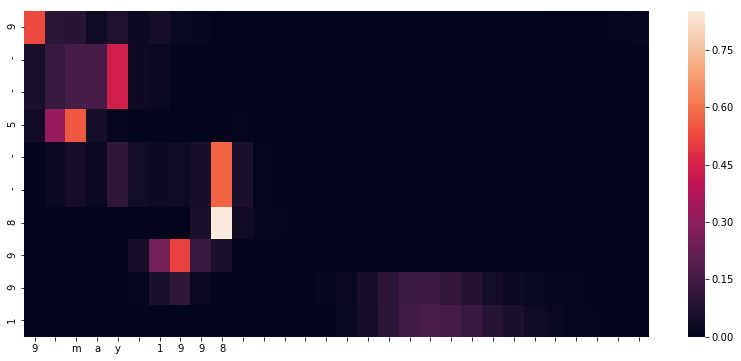

In [45]:
plt.clf()
plt.figure(figsize=(14,6))

ax = seaborn.heatmap(attention_density[:len(date), : len(text)],
        xticklabels=[w for w in text],
        yticklabels=[w for w in date])

ax.invert_yaxis()
plt.show()

In [72]:
model_json = model.to_json()
with open("../output/saved/date_model_attention_99.81.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../output/saved/date_weight_attention_99.81.hdf5")

C:\Users\boringtao\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
